# Problema: Information Retrieval
Text retrieval é uma tarefa em que o sistema responderá à query do usuario com documentos *relevantes*. A colecao de documentos relevantes é uma funçao da query $R(q)$ e é dependente do usuario. Portanto, vou encontar $R'(q)$, uma estimativa dos documentos relevantes - para encontar essa funcao, farei ranking onde a funcao $f(q,d)\in  \mathcal{R}$ é uma funcao de medida de relevancia. Existem varios algoritmos diferentes para computar $f(q,d)$. Dentre eles:

* ## Similarity based models:
Assumimos que se um documento é mais similar à query do que outro documento, entao o primeiro documento sera considerado mais relevante dp que o segundo - **vector space models**

* ## Modelos probabilisticos:
Assumimos que queries e docs sao observacoes de variaveis aleatorias. Assumimos que existe uma variavel binaria $R \{0,1\}$ que indica se o documento é relevante ou nao. O **score do documento** é entao definido como a **probabilidade** da variavel aleatoria $R$ ser igual a 1.


[M. Pannu et. al, 2014 A Comparison of Information Retrieval Models](https://www.researchgate.net/publication/265913721_A_Comparison_of_Information_Retrieval_Models)



Esses modelos sao todos baseados que usamos "bag of words" para representar o texto. Portanto, o score so doc dependera do score de cada palavra individual. O score das palavras é determinado pela frequencia com a qual elas aparecem no documento. Assim, dando match com um termo raro na colecao de palavras vai contribuir mais para o score total do que dar match com um termo comum.



***
***
# Sumário

* # 1. [Análise exploratória](#analise_expl)
    * ## 1.1. [Entendendo os dados](#analise_expl)
    * ## 1.2. [Pré-preocessamento: limpar e preparar dados](#limpar_preparar)
    * ## 1.   [Vetorizar query e features de produtos usando TF-IDF](#TF-IDF)

Analise do numero de cliques e vendas para as palavras mais frequentes

    * ## 1.?. [Análise de Frequencia](#analise_freq)
    
 Quais sao as palavras mais comuns? Quais sao as palavras mais comuns por par query-product?
 - construcao de sinonimos: sempre que alguem buscar por 'lembrancinha' eu busque tambem por 'natal', por exemplo
<br>


* # 2. [Construção do Índice](#construcao_ind)
Armazenar texto de forma mais inteligente.  Ele vai separar o texto inserido em algo pesquisavel, como grafemas, separar preposicoes dos artigos. 
Quando criamos um indice, sempre que inserimos uma nova linha no banco de dados, ele ja faz algumas operacoes para otimizar a busca naquele campo.
Esse indice pode estar em varias colunas diferentes. Assim, quando for buscar uma palavra, o codigo vai nas colunas para procura-las


Existem dois estagios principais na construcao de um search engine para arquivos de texto: construcao de indice, e usar indices para responder as queries. Alem disso, temos tambem o rankeamento deresltados (tf-idf, bm25 etc)
<br>


* # 3. [Ranking](#ranking)
Depois de criar o indice, temos que utiliza-lo. Podemos construir um modelo, que procure match entre as palavras da query e as palavras das colunas textuais (que foram indexadas). E depois trazer os resultados ordenados por relevancia

<br>


* # 4. [Análise dos resultados](#analise_result)


***
***

In [1]:
#importar bibliotecas

import numpy as np
import matplotlib.pyplot as plt
#frequency cloud plot
from wordcloud import WordCloud

import seaborn as sns
import pandas as pd

plt.style.use('ggplot')

#processamento de linguagem natural
#tokenizacao, lemmatizacao em portugues

import spacy
#chamar modelo em portugues
nlp = spacy.load("pt_core_news_sm")

import re
import string
import nltk
#regular expressions biblioteca para detectar padroes em texto


2023-02-05 15:40:16.210590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='analise_expl'></a>
#  1. Análise exploratória

Nesse estagio, vou me familiarizar com os dados para criar intuição sobre o problema e assim, ser capaz de começar a formular hipóteses testáveis.

## Carregando dados

In [2]:
pd.set_option('display.max_colwidth', None)

df_pairs = pd.read_csv("../dados/pairs.csv")#, delimiter=";")
df_products = pd.read_csv("../dados/products.csv")#, delimiter=";")

# 1.1. Entendendo os dados
Vamos olhar para as caracteristicas basicas do banco de dados
* Dataframe shape
* head and tail
* dtypes

Vamos começar vendo o que tem dentro de cada dataframe

In [3]:
# features da relação entre o par query e produto
print(df_pairs.info())
print(df_pairs.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89832 entries, 0 to 89831
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   pair_id            89832 non-null  int64 
 1   product_id         89832 non-null  int64 
 2   query              89832 non-null  object
 3   search_position    89832 non-null  int64 
 4   print_count_query  89832 non-null  int64 
 5   view_count_query   89832 non-null  int64 
 6   cart_count_query   89832 non-null  int64 
 7   order_count_query  89832 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 5.5+ MB
None
(89832, 8)


In [4]:
df_pairs.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,8589934593,14817,Convite Padrinhos Batismo,319,2374,18,1,0
1,8589934636,14884,Decoracao De Casamento,254,388,1,0,0
2,8589934836,8589934668,Toalha De Lavabo,233,219,2,0,0
3,8589934727,17179884005,Calendario 2023 Editavel,40,4871,2,0,0
4,8589934934,25769803777,Ecobag,286,166,3,0,0


Coluna com texto:
* query

In [5]:
print(df_products.info())
print(df_products.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76770 entries, 0 to 76769
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           76770 non-null  int64  
 1   title                76770 non-null  object 
 2   tags                 76770 non-null  object 
 3   creation_date        76770 non-null  object 
 4   price                76770 non-null  float64
 5   weight               76719 non-null  float64
 6   express_delivery     76770 non-null  int64  
 7   category             76762 non-null  object 
 8   minimum_quantity     76770 non-null  int64  
 9   print_count_product  76770 non-null  int64  
 10  view_count_product   76770 non-null  int64  
 11  cart_count_product   76770 non-null  int64  
 12  order_count_product  76770 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 7.6+ MB
None
(76770, 13)


In [6]:
#features de produtos
df_products.head()

,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product
0,101,Jogo Banheiro de Crochê de 3 Peças,"['#jogobanheiro #croche #tapetes', 'decoração', 'nas cores chumbo e rosa bebê']",2022-09-25 13:43:36,110.0,1.0,1,Técnicas de Artesanato,1,11,0,0,0
1,106,Guardanapos de Tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversário']",2014-12-26 18:47:48,269.5,0.0,0,Casa,1,62,6,0,0
2,47,Toalha Papai Noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mão', 'crochê', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,Casa,1,423,4,0,0
3,8589941942,Caixa para 1 bis feliz natal cliente como você sempre quero,"['lembrança', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartão de natal']",2021-11-22 15:02:30,45.0,0.0,0,Lembrancinhas,30,2746,93,6,2
4,17179869192,Árvore de Natal decorada em MDF,"['#madajoartesanato', '#decoraçaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,Decoração,1,1010,4,0,0


colunas de texto
* title
* tags 
* category

# 1.2 Pré-analise - analise "no olho"
Vamos olhar as features do produto mais clicado por query.

Essa analise inicial sera feita manualmente com um numero baixo de queries (20). Queremos detectar a presença de algum tipo de padrao. Aqui, queremos entender mais sobre o problema, respondendo as seguintes perguntas:
* 1. Quais features textuais parecem mais relevantes para o match (title, tags e category)?
* 2. Quais estruturas textuais importam para o match produto query? 
    * é um match de keyword? 
    * é um match semantico?
    
    
A principio, vamos analisar as colunas

* title
* tags
* category
* query



e usar como medida da relevancia de um determinado produto por query os dados de
* view_count_query - número de cliques que o produto recebeu a partir de sua aparição nos resultados da busca para a consulta query
* cart_count_query - número de vezes que o produto foi adicionado ao carrinho a partir de sua aparição nos resultados da busca para a consulta query
* order_count_query - número de vezes que o produto foi comprado a partir de sua aparição nos resultados da busca para a consulta query



## Remover Null values
Vamos examinar se temos algum valor faltante nos dataframes. Dos outputs abaixo, parece que apenas as colunas **weight** e **category** do dataframe **df_products** tem valores faltantes

In [7]:
print("---- df_pairs ----")
for col in df_pairs.columns:
    print(col, df_pairs[col].isnull().sum())
print("\n")


print("---- df_products ----")
for col in df_products.columns:
    print(col, df_products[col].isnull().sum())
print("\n")

---- df_pairs ----
pair_id 0
product_id 0
query 0
search_position 0
print_count_query 0
view_count_query 0
cart_count_query 0
order_count_query 0


---- df_products ----
product_id 0
title 0
tags 0
creation_date 0
price 0
weight 51
express_delivery 0
category 8
minimum_quantity 0
print_count_product 0
view_count_product 0
cart_count_product 0
order_count_product 0




In [8]:
#removendo linhas com valores faltantes
df_products.dropna(inplace=True)
#arrumar indices depois de remover linhas nan
df_products.reset_index(inplace=True)

print("---- df_products ----")
for col in df_products.columns:
    print(col, df_products[col].isnull().sum())
print("\n")

df_products.info()
#removemos 59 linhas

---- df_products ----
index 0
product_id 0
title 0
tags 0
creation_date 0
price 0
weight 0
express_delivery 0
category 0
minimum_quantity 0
print_count_product 0
view_count_product 0
cart_count_product 0
order_count_product 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76711 entries, 0 to 76710
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                76711 non-null  int64  
 1   product_id           76711 non-null  int64  
 2   title                76711 non-null  object 
 3   tags                 76711 non-null  object 
 4   creation_date        76711 non-null  object 
 5   price                76711 non-null  float64
 6   weight               76711 non-null  float64
 7   express_delivery     76711 non-null  int64  
 8   category             76711 non-null  object 
 9   minimum_quantity     76711 non-null  int64  
 10  print_count_product  76711 non-null  int64  
 11  view_cou

In [9]:
df_products['title'][3519]

'Tubolata 7x5 Personalizada Safari'

## Criar dataframe
Vamos criar um dataframe com os produtos mais clidados com as colunas
* title
* tags
* category
* query

* view_count_query 
* cart_count_query 
* order_count_query 
* search_position - número da posição em que o produto apareceu dentro da página de busca (mín 1 e máx 400)
juntando df_pairs e df_products com a chave primaria *product_id*

## Distribuicao do numero de compras pela query

O par produto-query com o maior numero de vendas teve  61  vendas


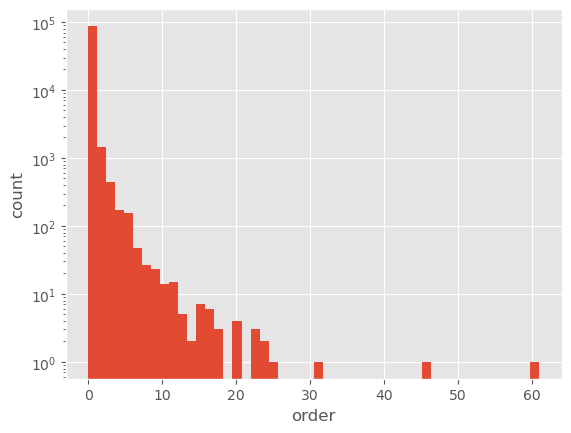

In [10]:
#distribuicao do numero total de compras a partir da aparição dos produtos
#nos resultados da busca para a consulta query

ax = df_pairs['order_count_query'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("order")
ax.set_ylabel("count")


print("O par produto-query com o maior numero de vendas teve ",df_pairs['order_count_query'].max(), " vendas")

In [11]:
n_vendas_par = 13

print("Numero de produtos com mais de", n_vendas_par, "vendas dado uma query é",
      df_pairs[df_pairs['order_count_query'] >= n_vendas_par].count()['product_id'])

Numero de produtos com mais de 13 vendas dado uma query é 36


### pegar features de produto associados a esses pares query-produto

In [12]:
df_popular_par = df_pairs[df_pairs['order_count_query'] >= n_vendas_par]
df_pop_par = df_popular_par.merge(df_products, on="product_id", how="left")
df_pop_par = df_pop_par[['pair_id', 'query', 'product_id', 'title', 'tags', 'category', 'search_position', "order_count_query"\
           ]]

print(df_pop_par.shape)

(36, 8)


In [13]:
#visualizar features, ordenando pelo maior numero de vendas
df_pop_par.sort_values(by=['order_count_query'], ascending=False).head(36)

,pair_id,query,product_id,title,tags,category,search_position,order_count_query
34,377957122385,Lembrancinha De Natal,8513,Sousplat crochê,"['crochê', 'sousplat', 'crochet', 'croche', 'mesa posta', 'suporte pratos', 'decoração mesa', 'jogo americano']",Casa,2,61
33,171798692060,Lembrancinha De Natal,8589934680,Guirlanda em Palha Porta 36cm Decoração de Natal,"['guirlanda', 'guirlanda natal', 'natal', 'porta', 'festão', 'berry', 'glitter', 'laço', 'natalina']",Decoração,9,46
3,1443109011833,Manual Dos Padrinhos,25769815661,Biquíni de Crochê,"['bikini', 'biquíni', 'biquine', 'crochet', 'crochê', 'cortininha', 'cropped', 'ciganinha', 'top', 'crocheperfeito', 'crochetaria', 'fio dental', 'calcinhas', 'praia', 'neon', 'tricot', 'tomara que caia', 'babadinho', 'cavado']",Roupas,1,31
20,103079215473,Lembrancinha De Natal,25769804360,Bloco de anotações personalizado,"['bloco de notas com nome', 'mimo para professores', 'bloco com nome', 'dia dos pais', 'ecológico', 'datas comemorativas', 'presente escola', 'brindes de final de ano', 'rematrícula', 'corpirativo', 'brindes empresas']",Lembrancinhas,3,25
29,790273982769,Porta Guardanapo,17179874020,CHINELO - Formatura Medicina,"['sandalia personalizada', 'brinde formatura', 'chinelo personalizado', 'chinelo formatura', 'medicina', 'sandalias personalizadas', 'chinelo personalizado enfermagem', 'sandalia personalizada medicina', 'formatura de medicina', 'lembrancinha medicina', 'chinelo para formatura', 'chinelo personalizado para formatura', 'chinelos de formatura', 'chinelos formatura', 'chinelos para formatura', 'sandalia de formatura', 'sandalia para festa de formatura', 'sandalia para formatura', 'sandalias de formatura', 'sandalias formatura', 'sandalias para festa de formatura', 'sandalias para festas de formatura', 'sandalias para formatura', 'sandalias para formaturas', 'sandalias personalizadas formatura', 'chinelos medicina', 'sandalias para festa de formatura medicina', 'sandalias personalizadas para formatura medicina', 'sandalias personalizadas formatura medicina', 'sandalias para formatura medicina', 'chinelo personalizado para formatura medicina', 'sandalias de formatura medicina', 'chinelo para formatura medicina', 'chinelos de formatura medicina', 'sandalia para festa de formatura medicina', 'sandalias formatura medicina', 'sandalia para formatura medicina', 'sandalia de formatura medicina', 'sandalias para festas de formatura medicina', 'sandalias para formaturas medicina', 'medicina', 'formando', 'chinelo medicina', 'sandália medicina', 'sandálias medicina', 'formado em medicina', 'lembrancinha medicina', 'lembrancinhas medicina', 'medicina', 'brindes medicina', 'brinde medicina']",Lembrancinhas,1,24
23,816043786323,Suculentas Lembrancinhas,8589949704,Caixa Milk Homem Aranha,"['caixa leite mickey', 'caixa milk mickey', 'caixa mickey', 'festa mickey', '3d', 'homem aranha', 'spider man', 'caixa leite homem aranha', 'caixa tipo milk homem aranha', 'milk', 'leite', 'homem aranha 3d', 'novo homem aranha']",Aniversário e Festas,3,24
35,1194000908673,Lembrancinhas De Casamento,10754,Topo De Bolo Casamento,"['topo de bolo', 'noivos', 'violão']",Aniversário e Festas,1,23
11,1451698946138,Lembrancinha Cha De Revelacao,8589943254,Vela aromática pote patê com tampa personalizada,"['vela', 'velapersonalizada', 'lembrança', 'lembrancinha', 'pote patê', 'vela pote patê', 'vela vidro preto', 'vela tampa madeira', 'maternidade']",Lembrancinhas,1,23
32,85899346198,Copos Para Lembrancinhas,17179884357,Adesivo Marmitinha MARIA CLARA E JP,"['rótulo', 'adesivo', 'lembrancinha', 'festa', 'colante', 'personalizado', 'arte', 'rotulo', 'rótulos', 'rotulos', 'adesivos', 'rotulo adesivo', 'rótulos adesivos', 'rótulo adesivo', 'rotulos adesivos', 'papel colante', 'adesivo multiuso', 'adesivos personalizados', 'papelaria de festa', 'sacola personalizada', 'adesivo tubete personalizado', 'adesivo latinha personalizado', 'adesivo caixinha personalizado', 'festa de aniversário', 'maria clara e jp', 'a

A principio a maior parte dessas queries nao parece ter match imediato (metodos de match keyword com keyword provavelmente nao vao devolver bons resultados) com os titulos e descricoes dos produtos vendidos. As queries e as sao **ambiguas** - nao ha uma semantica bem definida para especificar quais produtos a serem retornados 

Por ex:
query: Lembrancinha de Natal 
title: Sousplat crochê

Alem disso, porque nao parecem haver respostas certas para uma mesma query (a resposta para a query Lembrancinha de Natal pode ser tanto "Sousplat croche" quanto "Guirlanda em Palha") vamos recorrer a uma analise empirica envolvendo as respostas dos usuarios (numero de cliques pos query, numero de vendas pos query) para saber qual metodo funciona melhor. 

## Distribuicao do numero de itens adicionados ao carrinho pela query

O par produto-query com o maior numero de vendas teve  183  vendas


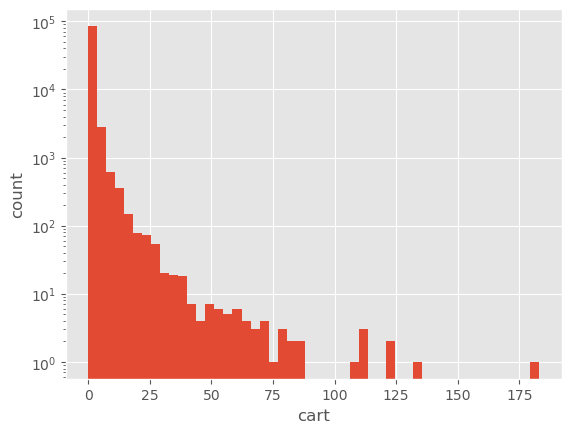

In [14]:
ax = df_pairs['cart_count_query'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("cart")
ax.set_ylabel("count")


print("O par produto-query com o maior numero de vendas teve ",df_pairs['cart_count_query'].max(), " vendas")

## Distribuicao do numero cliques pela query

O par produto-query com o maior numero de vendas teve  4529  vendas


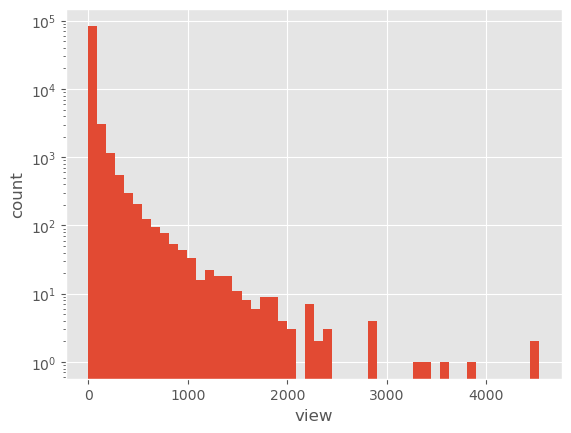

In [15]:
ax = df_pairs['view_count_query'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("view")
ax.set_ylabel("count")

print("O par produto-query com o maior numero de vendas teve ",df_pairs['view_count_query'].max(), " vendas")

Text(0, 0.5, 'count')

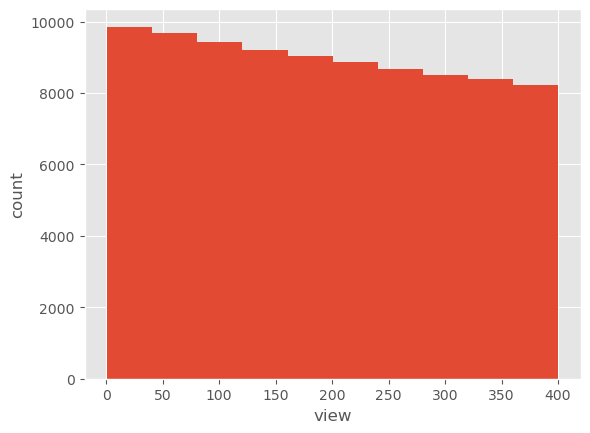

In [16]:
ax = df_pairs['search_position'].plot(kind='hist', bins=10)#, log=True)
ax.set_xlabel("view")
ax.set_ylabel("count")

#print("O par produto-query com o maior numero de vendas teve ",df_pairs['view_count_query'].max(), " vendas")

<a id='limpar_preparar'></a>
#  1.3. Pré-processamento: limpar e preparar dados

Vamos preparar/limpar nossos dados para a análise exploratoria. Para decidir o que fazer nesse estagio, vamos relembrar qual é o nosso problema: queremos criar um modelo que seja capaz de, dada uma query, retornar produtos mais relevantes (baseados nas suas descricoes) e recomendar produtos diferentes.

Portanto, no estagio de limpeza de dados é interessante:
* Que o algoritmo seja capaz de detectar palavras com errors ortograficos como iguais. Ex:
            guardanapos = gurdanapo
            aniversário = aniversario
            
* remover captalizacao, para que o algoritmo nao diferencie, por ex.: guardanapos de Guardanapos

* Queremos remover inflexoes das palavras -> lemmetizacao

* Remover palavras que nao acrescentam signifcado ao texto (stopwords)

* Queremos lidar com ambiguidade à nível de palavras. Por exemplo, uma mesma palavra pode ser um substantivo ou um adjetivo (e.g. rosa)



No fim, queremos fazer o computador entender as queries e descricoes dos produtos, para entao, poder compara-las. Assim, seguiremos as seguintes etapas:

* 1. Remover Null values
* 2. Tokenization 
* 3. Remover pontuações
* 4. Remover stopwords
* 5. Converter todos os caracteres para letras minusculas
* 6. POS
* 7. Lemmatization/Steming
* 8. Word embedding


### Lematization or steming
Dependendo do quão elaborado seja o algoritmo da lemmatization, ele pode gerar associação entre sinônimos tornando essa técnica muito mais rica nos resultados, como relacionar a palavra trânsito e a palavra engarrafamento. Este mesmo resultado não aconteceria na técnica stemming que apenas reduziria essas palavras. Assim, essa técnica não é a ideal em idiomas morfologicamente mais complexos.

Stemming ainda pode gerar dois tipos de problemas como: cortar demais e acabar com um stem que não tem sentido e perdeu muito de sua informação; ou também cortar demais e ter dois stem iguais para palavras com significados muito diferentes. A lemmatization é mais lenta, mas garante que vai gerar palavras gramaticalmente corretas e com maior precisão já que leva a classe gramatical em consideração.

* Stemming é mais comumente usada por mecanismos de busca para indexar palavras.
* Já a lemmatization tem seu uso interessante junto a técnica como vetorização de palavras (word vectors), Tf-idf e LDA para modelagem de tópicos onde, eliminando plurais e utilizando sinônimos, podemos ter um aumento de precisão nessas técnicas

<a id='pontuacao'></a>


## 1.3.2 Normallizar, Remover pontuação e tokenizar

Anteriormente, vimos que as colunas que contem dados em forma de texto sao:
* em df_pair:
    * query
    
* em df_products:
    * title
    * tags 
    * category    

Com os pré-processamentos, queremos reduzir o tamanho do vocabulário e simplificar algumas formas lexicais, garantindo, assim, que o algoritmo obtenha informações relevantes e que de fato representam o nosso os produtos e as queries

## Normalizar
Vamos colocar tudo em letras minusculas e remover acentos

In [17]:
cols = df_products.select_dtypes(include=[np.object]).columns

#remover acentos
df_products[cols] = df_products[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
# todos os caracteres em letra minuscula
df_products[cols] = df_products[cols].apply(lambda x: x.str.lower())

df_products

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_35463/2774456531.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = df_products.select_dtypes(include=[np.object]).columns


,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76706,76765,12277,sacolinha para lembrancinhas,"['sacola para lembrancinhas', 'lembrancinhas', 'sacola', 'sacolinhas', 'sacolinha para lembrancinha']",2012-01-29 02:56:46,39.0,100.0,0,bolsas e carteiras,10,117,3,0,0
76707,76766,17945,kit pulseira e gravatas para padrinhos verde tiffany,"['manual para padrinhos', 'lembranca madrinhas', 'madrinhas', 'casamento', 'manual casamento', 'madrinha', 'mimos para madrinhas', 'mymos com amor da edith', 'mymos com amor', 'pulseira para madrinha', 'casamento 2018', 'casamento 2019', 'pulseiras de perolas']",2020-01-11 18:13:16,192.8,20.0,0,casamento,4,2130,53,1,0
76708,76767,8589938478,vestido de noiva princesa novo,"['vestido de noiva', 'noiva', 'casamento', 'noivas rj', 'vestido civil', 'noivinha', 'vestido branco noiva', 'vestido branco', 'vestido princesa', 'voucasar', 'noivado', 'noivasrio', 'vestido de noiva barato', 'vestido de festa']",2020-07-04 18:37:05,490.0,0.0,1,roupas,1,3840,72,0,0
76709,76768,17179881527,papai noel amigurumi,"['presente', 'brinquedo', 'artesanato', 'artesanato croche', 'infantil', 'decoracao infantil', 'pelucia', 'crianca', 'decoracao bebe', 'boneco', 'papai noel amigurumi', 'papai noel', 'noel', 'papai noel croche', 'natal', 'decoracao natal']",2018-10-21 14:29:26,165.0,150.0,1,tecnicas de artesanato,1,2077,19,1,0


In [18]:
cols = df_pairs.select_dtypes(include=[np.object]).columns
#remover acentos
df_pairs[cols] = df_pairs[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
# todos os caracteres em letra minuscula
df_pairs[cols] = df_pairs[cols].apply(lambda x: x.str.lower())
df_pairs

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_35463/2086999200.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = df_pairs.select_dtypes(include=[np.object]).columns


,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0
1,8589934636,14884,decoracao de casamento,254,388,1,0,0
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0
4,8589934934,25769803777,ecobag,286,166,3,0,0
...,...,...,...,...,...,...,...,...
89827,1529008357415,9477,lembrancinha safari,58,6149,138,3,0
89828,1529008357501,17179878562,convite transparente em acetato impressao colorida,99,71,0,0,0
89829,1529008357505,17179878565,lembrancinha chaveiro,77,706,5,0,0
89830,1529008357518,17179878580,bolo do brasil,264,6,0,0,0


In [19]:
#criar uma lista com pontuações
punctuations = string.punctuation 
print(punctuations)

# criar uma lista de stop words em portugues
nltk.download('stopwords')

# para escolher as stopwords do português adicionamos a opçaõ de língua "portuguese" stop_words.words('portuguese')

stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabriela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

<a id='tokenization'></a>

# 1.3. Tokenization

Tokenizacao é uma etapa crucial de processamento de linguagem natural. Aqui, reduzimos os textos em *unidades lexicais* de forma que a maquina consiga mapear com sucesso, palavras de sentidos similares ao mesmo indice.

## Word Tokenization

Vamos quebrar os textos bruto em em tokens de palavras, remover stopwords, pontuacao e usar a lemmatizacao para tentar remover inflexoes


In [20]:
#testando tokenizador


from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()
#[stemmer.stem(palavra) for palavra in df_palavras['Original']]



#spacy token para remocao de pontuacoes e lematizacao em pt
text = '##eu como e durmo na minha cama. nas cores \ |\|meus pais ##gostam de dormir nas 5 camas azuis e rosas e rosa deles. tenho lembranca, lembrancinha e mais lembrancinhas #&'

text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

#replace extra spaces with single space
text = re.sub(' +',' ',text)

#remover espacos vazios no comeco e final da string
text = text.strip()
print(text)
tokens_spacy = nlp(text)

#nltk token para remocao de stopwords
tokens_nltk = word_tokenize(text)

tokens = []
for i, word in enumerate(tokens_nltk):
    if word not in stop_words:
        #lemmatizar tudo o que nao é stopword
        word_new = tokens_spacy[i].lemma_.lower().strip() 
        tokens.append(word_new)  
        
tokens

eu como e durmo na minha cama nas cores meus pais gostam de dormir nas 5 camas azuis e rosas e rosa deles tenho lembranca lembrancinha e mais lembrancinhas


[nltk_data] Downloading package punkt to /Users/gabriela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /Users/gabriela/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


['durmo',
 'cama',
 'cor',
 'pai',
 'gostar',
 'dormir',
 '5',
 'cama',
 'azul',
 'rosa',
 'roso',
 'lembranca',
 'lembrancinhar',
 'lembrancinha']

In [21]:
def word_tokenizer_lemma(sentence):
    
    #remove todos os caracteres especiais
    sentence = re.sub(r"[^a-zA-Z0-9]+", ' ', sentence)
    
    #substituir espacos estras por um unico espaco 
    sentence = re.sub(' +',' ',sentence)

    #remover espacos vazios no comeco e final da string
    sentence = sentence.strip()
    
    #spacy: token para a lemmatizacao
    tokens_spacy = nlp(sentence)

    #nltk: token para remocao de stopwords
    tokens_nltk = word_tokenize(sentence)

    
    # lemmatizar, remover stopwords
    tokens = []
    for i, word in enumerate(tokens_nltk):
        #remover stopwords
        if word not in stop_words:
            #lemmatizar
            word_new = tokens_spacy[i].lemma_.lower()
            
            tokens.append(word_new) 
                               
    return tokens


In [22]:
df2_products = df_products.copy()
df2_pairs = df_pairs.copy()

print ('Cleaning and Tokenizing...\n----------------------------- \n----------------------------- \n')

cols = ['title', 'tags', 'category']

print("--- Products dataframe ---")
for i in cols:
    print('Processing column:', i)
    %time df2_products[i+'_tokenized'] = df2_products[i].map(lambda x: word_tokenizer_lemma(x))  


print("\n\n--- Pairs dataframe ---")
%time df2_pairs['query_tokenized'] = df2_pairs['query'].map(lambda x: word_tokenizer_lemma(x)) 

print("\n\nDone!")



df2_products.to_csv('../dados/df_products_token_lemma_list.csv')  
df2_pairs.to_csv('../dados/df_pairs_token_lemma_list.csv')

Cleaning and Tokenizing...
----------------------------- 
----------------------------- 

--- Products dataframe ---
Processing column: title
CPU times: user 3min 45s, sys: 676 ms, total: 3min 45s
Wall time: 3min 46s
Processing column: tags
CPU times: user 8min 55s, sys: 644 ms, total: 8min 55s
Wall time: 8min 55s
Processing column: category
CPU times: user 3min 11s, sys: 194 ms, total: 3min 11s
Wall time: 3min 11s


--- Pairs dataframe ---
CPU times: user 3min 54s, sys: 229 ms, total: 3min 54s
Wall time: 3min 54s


Done!


In [23]:
df2_products.head()

,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0,"[jogo, banheiro, croche, 3, peca]","[jogobanheiro, crochar, tapete, decoracao, cor, chumbo, roso, beber]","[tecnica, artesanato]"
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, guradanapo, festa, evento, 15, ano, casamento, aniversario]",[casa]
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0,"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, crochet]",[casa]
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2,"[caixar, 1, bis, feliz, natal, cliente, voce, sempre, querer]","[lembranca, personalizar, festa, caixa, caixinho, rose, gold, folha, folhagem, verde, branco, verde, branco, minnie, roso, minnie, rosa, jardim, jardim, encantar, far, morena, fadinha, pj, pjmask, natal, ano, novo, feliz, natal, brinde, corporativo, card, bis, cartao, natal]",[lembrancinha]
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0,"[arvore, natal, decorar, mdf]","[madajoartesanato, decoracaodenatal, enfeitedenatal, arvoredenataldecoradaemmdfr]",[decoracao]


In [24]:
df2_pairs.head(20)

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]"
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]"
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]"
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag]
5,8589934925,14852,sacolinha para lembrancinha,174,797,1,0,0,"[sacolinha, lembrancinhar]"
6,8589934953,14871,planner,371,424,4,0,0,[planner]
7,8589934757,17179876606,bolo do brasil,341,1,0,0,0,"[bolo, brasil]"
8,8589934635,14883,vendedor,40,37,0,0,0,[vendedor]
9,8589934959,25769803799,saida maternidade menino,9,17363,218,2,1,"[saido, maternidade, menino]"


## 1. BPE tokenizer
Criar tokens de sub-palavras à partir do corpo de documentos. Pra isso, ele precisa treinar sob todo o corpo para aprender a identificar os tokens mais apropriados.

BPE é um tokenizador muito utilizado. A vantagem desse tokenizador 
* palavras frequentes sao mantidas e nao segmentadas
* palavras raras sao segmentadas em tokens de subpalavra


Esse tokenizador sera especialmente util para lidar com a coluna de *tags_produtos* que contem palavras como: jogobanheiro

In [25]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [26]:
df2_products.columns

Index(['index', 'product_id', 'title', 'tags', 'creation_date', 'price',
       'weight', 'express_delivery', 'category', 'minimum_quantity',
       'print_count_product', 'view_count_product', 'cart_count_product',
       'order_count_product', 'title_tokenized', 'tags_tokenized',
       'category_tokenized'],
      dtype='object')

In [27]:
# criar dataframe com todos os dados textuais
df2_all = df2_pairs.merge(df2_products, on="product_id", how="inner")
df2_all.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized,index,...,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]",25523,...,0,jogos e brinquedos,1,3728,466,8,3,"[beber, reborn, menino, promocao]","[beber, reborn, bebe, reborn, promocao, boneca, beber, reborn, menino, beber, reborn, olho, abrir, beber, reborn, barato, beber, reborn, molde, mary, beber, reborn, silicone]","[jogo, brinquedo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]",25619,...,0,infantil,1,192,9,1,0,"[quadro, incentivo, patrulha, canino]","[quadro, incentivo, patrulha, canino, quadro, incentivo, patrulha, canino, quadro, tarefa]",[infantil]
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]",15931,...,0,lembrancinhas,50,878,49,4,1,"[mini, topper, docinho, personalizar, tema, cha, revelacao]","[delicate, lembrancinha, lembrancinhapersonalizada, personalizar, topper, topper, doce, mini, topper, festa, personalizar, festa, casa, docinho, festa, doce, festa, revelacao, char, revelacao]",[lembrancinha]
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]",25564,...,0,acessorios,1,1113,27,1,0,"[chaveiro, resina, personalizar]","[chaveiro, chaveiro, chaveiro, resina, lembrancinhar, chaveiro, chaveiro, lembrancinha, epoxi, resina, resino, epoxi, lembrancinha, lembrancinhar, chaveiro, letra, chaveiro, letra, resina, letra, chaveiro, personalizar, pompom, chaveiro, pompom, alfabeto, presente, tassel, cha, bebe, casamento, madrinha, padrinho, noivo, handmade, personalizar, lembrancer, personalizar, enfeite, artesanal, artesanato, batizar, aniversario, letra, resina, nome, resina, numero, numero, resina]",[acessorio]
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag],18820,...,0,aniversario e festas,1,9370,469,5,0,"[chaveiro, safari, amigurumer, lembrancinha]","[aniversario, safari, safari, menina, lembrancinha, lembranco, aniversario, lembranca, nascimento, festa, safari]","[aniversario, festa]"


In [28]:
# -- Atencao -- Rodar uma vez!

#tokenized_columns = ['query_tokenized','title_tokenized', 'tags_tokenized',
#       'category_tokenized']

#escrever arquivo raw que o tokenizador consiga ler e treinar
#with open('tokenizer_data/train_tokenizer_lemma_all.raw', 'w+') as fp:
    
    # olhar dataframe com itens pre tokenizados linha a linha
#    for _,linha in df2_all.iterrows():
        
        #selecionar coluna
#        for column in tokenized_columns:
            
#            lista = linha[column]

            # selecionar palavra dentro da lista
#            for element in lista:
#                fp.write(f"{element} \n")

In [29]:
# se o meu corpo de documentos nao for grande o suficiente
# terei um conjunto de silabas desconhecido [UNK]
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

tokenizer.pre_tokenizer = Whitespace()


#vocab_size é a quantidade tokens que o algoritmo vai ter no final. quanto maior
# vocab_size maiores serao os tokens
trainer500 = BpeTrainer(vocab_size=500, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

#treinar tokenizador em todos os documentos
%time tokenizer.train(files=["tokenizer_data/train_tokenizer_lemma_all.raw"], trainer=trainer500)




CPU times: user 14.2 s, sys: 7.52 s, total: 21.7 s
Wall time: 3.89 s


In [30]:
#vocab_size = 500
output500 = tokenizer.encode("reborn lembrancinha de jogobanheiro guradanapo")
output500.tokens

['reborn',
 'lembrancinha',
 'de',
 'jogo',
 'ban',
 'h',
 'eiro',
 'gu',
 'ra',
 'd',
 'ana',
 'po']

In [31]:
#vocab_size é a quantidade tokens que o algoritmo vai ter no final
# se o meu corpo de documentos nao for grande o suficiente
# terei um conjunto de silabas desconhecido


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer1000 = BpeTrainer(vocab_size=1000, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

%time tokenizer.train(files=["tokenizer_data/train_tokenizer_lemma_all.raw"], trainer=trainer1000)




CPU times: user 14.4 s, sys: 7.62 s, total: 22 s
Wall time: 3.98 s


In [32]:
#vocab_size = 1000
output1000 = tokenizer.encode("reborn lembrancinha de jogobanheiro guradanapo")
output1000.tokens

['reborn',
 'lembrancinha',
 'de',
 'jogo',
 'banheiro',
 'gu',
 'ra',
 'd',
 'ana',
 'po']

In [33]:
linha = ["reborn", "lembrancinha", "jogobanheiro"]
bpe_tokens = [tokenizer.encode(element).tokens for element in linha]
print(bpe_tokens)
# pra achatar a lista
import itertools
bpe_tokens =list(itertools.chain(*bpe_tokens))
bpe_tokens

[['reborn'], ['lembrancinha'], ['jogo', 'banheiro']]


['reborn', 'lembrancinha', 'jogo', 'banheiro']

## Aplicar tokenizador BPE no banco de dados

In [35]:
# pra achatar a lista
import itertools

In [36]:
#inicializar tokenizador
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

#vamos deixar vocab_size=1000 por conveniencia
trainer = BpeTrainer(vocab_size=1000, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

%time tokenizer.train(files=["tokenizer_data/train_tokenizer_lemma_all.raw"], trainer=trainer)




def bpe_tokenizer(sentence):
    'aplica a tokenizacao bpe linha a linha no dataframe'
    
    #criar objeto token 
    bpe_tokens = [tokenizer.encode(element).tokens for element in sentence]
    bpe_tokens = list(itertools.chain(*bpe_tokens))

    return bpe_tokens




CPU times: user 14.2 s, sys: 7.75 s, total: 22 s
Wall time: 3.92 s


In [37]:
print ('BPE tokenizing...\n-------------------------- \n-------------------------- \n')

cols_tokenized = ['title_tokenized', 'tags_tokenized', 'category_tokenized']

print("--- Products dataframe ---")
for i in cols_tokenized:
    print('Processing column:', i)
    %time df2_products[i+'_bpe'] = df2_products[i].map(lambda x: bpe_tokenizer(x))  


print("\n\n--- Pairs dataframe ---")
%time df2_pairs['query_tokenized_bpe'] = df2_pairs['query_tokenized'].map(lambda x: bpe_tokenizer(x)) 

print("\n\nDone!")

BPE tokenizing...
-------------------------- 
-------------------------- 

--- Products dataframe ---
Processing column: title_tokenized
CPU times: user 1.56 s, sys: 7.22 ms, total: 1.57 s
Wall time: 1.57 s
Processing column: tags_tokenized
CPU times: user 13.6 s, sys: 102 ms, total: 13.7 s
Wall time: 13.7 s
Processing column: category_tokenized
CPU times: user 763 ms, sys: 7.93 ms, total: 771 ms
Wall time: 770 ms


--- Pairs dataframe ---
CPU times: user 977 ms, sys: 8.84 ms, total: 986 ms
Wall time: 986 ms


Done!


In [38]:
df2_products[['title_tokenized', 'title_tokenized_bpe','tags_tokenized', 'tags_tokenized_bpe',\
              'category_tokenized', 'category_tokenized_bpe']].head()

,title_tokenized,title_tokenized_bpe,tags_tokenized,tags_tokenized_bpe,category_tokenized,category_tokenized_bpe
0,"[jogo, banheiro, croche, 3, peca]","[jogo, banheiro, croche, 3, pe, ca]","[jogobanheiro, crochar, tapete, decoracao, cor, chumbo, roso, beber]","[jogo, banheiro, cro, char, tapete, decoracao, cor, chu, m, bo, roso, beber]","[tecnica, artesanato]","[te, c, n, ica, artesanato]"
1,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, 10, 0, un, idade]","[guardanapo, tecido, guradanapo, festa, evento, 15, ano, casamento, aniversario]","[guardanapo, tecido, gu, ra, d, ana, po, festa, evento, 15, ano, casamento, aniversario]",[casa],[casa]
2,"[toalha, papai, noel]","[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, crochet]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, croche, t]",[casa],[casa]
3,"[caixar, 1, bis, feliz, natal, cliente, voce, sempre, querer]","[caixar, 1, bis, feliz, natal, cliente, vo, ce, sem, pr, e, qu, er, er]","[lembranca, personalizar, festa, caixa, caixinho, rose, gold, folha, folhagem, verde, branco, verde, branco, minnie, roso, minnie, rosa, jardim, jardim, encantar, far, morena, fadinha, pj, pjmask, natal, ano, novo, feliz, natal, brinde, corporativo, card, bis, cartao, natal]","[lembranca, personalizar, festa, caixa, caix, inho, rose, go, l, d, fol, ha, fol, h, agem, verde, branco, verde, branco, minnie, roso, minnie, rosa, jardim, jardim, encantar, far, m, or, en, a, f, ad, inha, p, j, p, j, mas, k, natal, ano, novo, feliz, natal, brinde, corporativo, car, d, bis, cartao, natal]",[lembrancinha],[lembrancinha]
4,"[arvore, natal, decorar, mdf]","[arvore, natal, decorar, mdf]","[madajoartesanato, decoracaodenatal, enfeitedenatal, arvoredenataldecoradaemmdfr]","[m, ada, jo, artesanato, decoracao, d, en, atal, enfeite, d, en, atal, arvore, d, en, atal, deco, ra, da, em, m, d, fr]",[decoracao],[decoracao]


In [39]:
df2_pairs[['query','query_tokenized', 'query_tokenized_bpe']].head()

,query,query_tokenized,query_tokenized_bpe
0,convite padrinhos batismo,"[convite, padrinho, batismo]","[convite, padrinho, batismo]"
1,decoracao de casamento,"[decoracao, casamento]","[decoracao, casamento]"
2,toalha de lavabo,"[toalha, lavabo]","[toalha, lavabo]"
3,calendario 2023 editavel,"[calendario, 2023, editavel]","[calendario, 2023, e, di, ta, vel]"
4,ecobag,[ecobag],[ecobag]


Imprime a frequencia com a qual essas palavras aparecem no banco de dados

# Analise da frequencia
Aqui queremos responder as seguintes perguntas:
* ### 1. Quais sao as palavras mais comuns nas queries?
* ### 2. Quais sao as palavras mais comuns nos produtos?
* ### 3. Parece existir correlacao entre palavras mais comuns nas queries e nos produtos?

In [40]:
#top 10 palavras mais frequentes nos titulos dos produtos
print("top 10 palavras mais frequentes nas queries\n", pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:10], "\n" )

top 10 palavras mais frequentes nas queries
 natal            12043
personalizar      7800
kit               6688
lembrancinhar     6388
maternidade       4371
croche            4220
casamento         3467
porta             3453
mesa              3444
convite           3000
dtype: int64 



In [41]:
#top 10 palavras mais frequentes nos titulos dos produtos
print( "top 10 palavras mais frequentes nos titulos dos produtos\n", pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:10], "\n"  )

print( "top 10 palavras mais frequentes nas tags dos produtos\n", pd.Series(np.concatenate(df2_products['tags_tokenized']))\
                                                    .value_counts()[:10], "\n"  )

print( "top 10 palavras mais frequentes nas categorias dos produtos\n", pd.Series(np.concatenate(df2_products['category_tokenized']))\
                                                    .value_counts()[:10] )

top 10 palavras mais frequentes nos titulos dos produtos
 natal            12043
personalizar      7800
kit               6688
lembrancinhar     6388
maternidade       4371
croche            4220
casamento         3467
porta             3453
mesa              3444
convite           3000
dtype: int64 

top 10 palavras mais frequentes nas tags dos produtos
 personalizar     89523
natal            82352
festa            70392
lembrancinhar    68619
decoracao        43589
casamento        37385
quadro           33076
convite          32758
presente         31813
infantil         30301
dtype: int64 

top 10 palavras mais frequentes nas categorias dos produtos
 lembrancinha    18704
festa           11645
aniversario     11117
decoracao       10585
beber            6105
papel            5449
cia              5289
casamento        4447
casa             3810
roupa            3401
dtype: int64


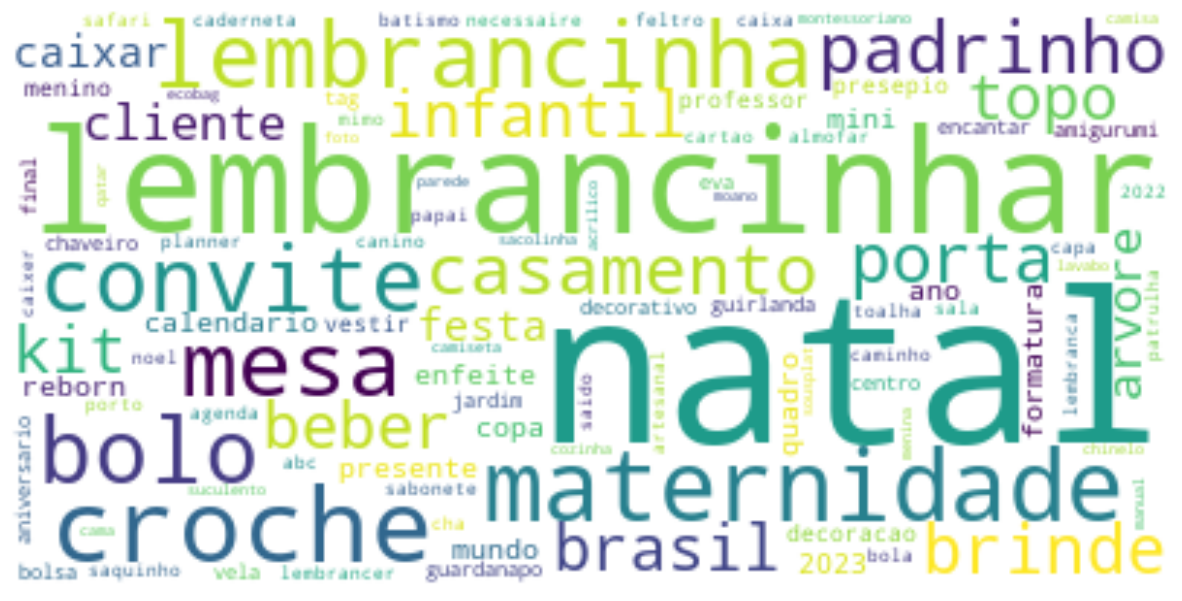

In [42]:
#queries
series = pd.Series(np.concatenate(df2_pairs['query_tokenized']))\
                                                    .value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

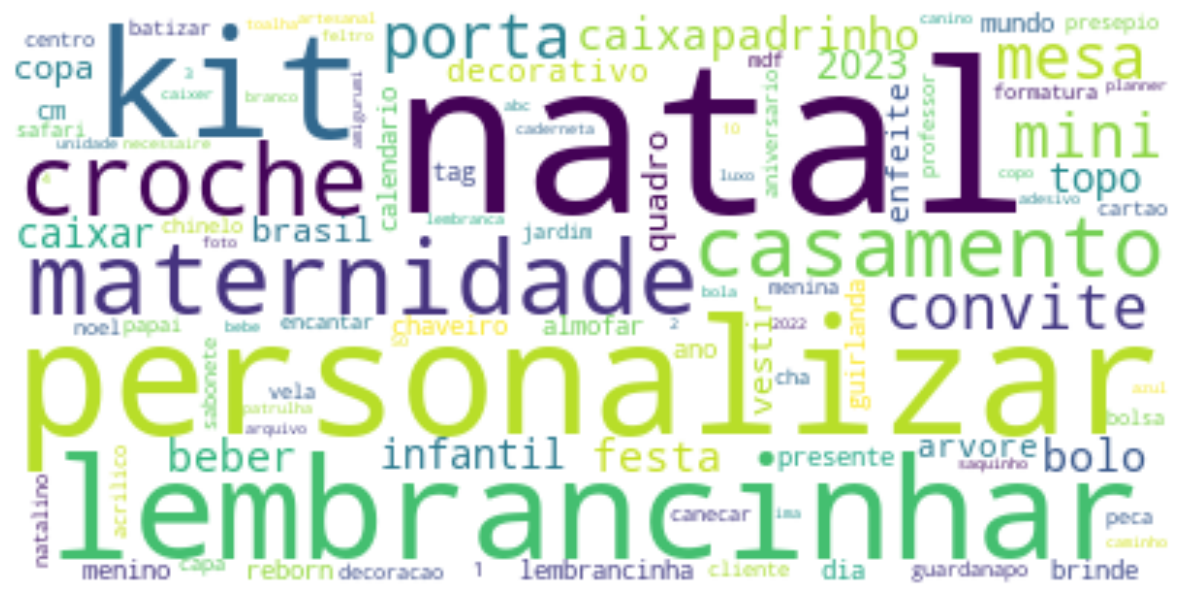

In [43]:
#tags
series = pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 2. Construcao do indice: 
O primeiro passo na construcao de um text search engine é montar um **inverted index**. Um inverted index é uma estrutura de dados que **mapeia tokens para os documentos** em que eles aparecem - ex.: pegar uma palavra e retornar uma lista dos documentos e localizacao em que ela aparece.

Nos ja tokenizamos, normalizamos e limpamos o copus de documentos no passo anterior. Para que possamos fazer **single word queries** e **phrase queries** (queries de palavras em uma sequencia especifica), precisamos armazenar tanto o documento que contem o token quanto *onde* em cada documento o token esta. Portanto, construirei um *objeto dictionary* na seguite estrutura:


            InverseIndex_dict = {'token1': [[doc_i_index, posicao_no_doc1],[doc_j_index, posicao_no_doc3], ...], 'token2': [[doc_k_index, posicao_no_doc_k],[doc_index_l, posicao_no_doc_], ...] ..., 'tokenN': [[doc_k_index, posicao_no_doc_k], ...]} 
            
Esse passo demora muito para ser computado, mas só precisa ser computado uma vez!

Para evitar uma varios *for loops* explicitos, vou criar funcoes de recuperacao de indices que por sua vez serao aplicadas à funcao **.apply()** da biblioteca pandas que fara o loop por palavras e documentos de forma mais eficiente.

In [98]:
#
#funcoes para criar dicionario de indice invertido! 
#

def funct_doc(doc, word, docs, column_name):
    """
    funcao de recuperacao de:
    idx       = indice de documento no corpo de documentos
    positions = posicao do token no doumento
    
    """
    if word in doc:
        idx = docs[docs[column_name].apply(lambda x: x==doc)].index[0]

        positions = list(np.where(np.array(doc) == word)[0])
                        
        return [idx, positions]
    
    return [np.nan, np.nan]
    
    

def funct_words(word, docs, column_name):
    """
    funcao que sera aplicada ao dataframe de vocabulario: unique_words
    
    Aplica funct_doc no corpo de documentos e armazena outputs 
    [idx, position] num dataframe auxiliar (df_aux)
    
    Remove np.nan do dataframe auxiliar e retorna uma lista de listas para cada token:
    [[doc_i_index, posicao_no_doc1],[doc_j_index, posicao_no_docj], ...]
    
    """
    
    df_aux = pd.DataFrame()
    
    df_aux[column_name] = docs[column_name].apply(lambda doc: funct_doc(doc, word, docs, column_name))
    
    list_por_token = list(df_aux[df_aux[column_name].apply(lambda x: x!=[np.nan, np.nan])][column_name]) 
    
    return list_por_token


In [99]:
#fazer teste

column_name = 'tags_tokenized_bpe'

docsteste = df2_products[:1000]

#cria lista de vocabulario das queries
all_docs_words = pd.DataFrame(np.concatenate(docsteste[column_name]), columns=['words'])
unique_words = all_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

# aplicamos a funcao funct_words em cada token na serie unique_tokens['words']
# armazenamos os inverse indexes de cada token numa nova coluna unique_words['inv_idx']
%time unique_words['inv_idx'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )


# pega o df de tokens e inv_idx e transforma em dicionario
dict_inv_idx_tags = dict(zip(unique_words.words, unique_words.inv_idx))

CPU times: user 8.18 s, sys: 35.6 ms, total: 8.21 s
Wall time: 8.22 s


In [104]:
print(dict_inv_idx_tags['natal'][0])
print(docsteste[column_name][2])
# passou no teste!

[2, [0, 2]]
['natal', 'toalha', 'natal', 'toalha', 'mesa', 'papai', 'noel', 'fazer', 'mao', 'croche', 'croche', 't']


Text(0, 0.5, 'doc corpus size')

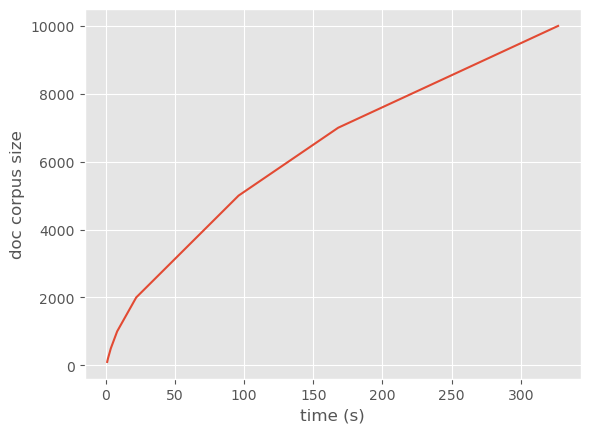

In [128]:
#como tempo do InverseIndex escala com o numero de documentos

time = np.array([ 1.02, 1.57, 3.64, 8.22, 22, 96, 168, 327])
size = np.array([100, 200, 500, 1000, 2000, 5000, 7000, 10000])
plt.plot(time,size)
plt.xlabel('time (s)')
plt.ylabel('doc corpus size')


In [116]:
#fazer teste

column_name = 'tags_tokenized_bpe'

docsteste = df2_products[:10000]

#cria lista de vocabulario das queries
all_docs_words = pd.DataFrame(np.concatenate(docsteste[column_name]), columns=['words'])
unique_words = all_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

# aplicamos a funcao funct_words em cada token na serie unique_tokens['words']
# armazenamos os inverse indexes de cada token numa nova coluna unique_words['inv_idx']
%time unique_words['inv_idx'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )


# pega o df de tokens e inv_idx e transforma em dicionario
dict_inv_idx_tags = dict(zip(unique_words.words, unique_words.inv_idx))

CPU times: user 5min 21s, sys: 3.41 s, total: 5min 24s
Wall time: 5min 27s


# 3. Ranking
Para 

# 3.1. Score BM25

Ranking BM25 se baseia em dois principios:

* **TF or Term Frequency** — indica o numero de ocorrencias do termo no documento
* **IDF or Inverse Document Frequency** — mede o quao importante o termo é usando as estatisticas gerais dos documentos - atribui um peso a cada termo tokenizado, onde, termos frequentes recebem peso menor (considerados menos relevantes) e termos menos frequentes recebem um peso maior (considerados mais relevantes)

Alem disso, BM25 melhora TF-IDF em dois aspectos cruciais
* **diminui retornos para termos muito frequentes**. Assim, se a query estiver procurando por uma termo especifico que é extremamente comum no corpo de documentos (ex.: lembrancinha), entao o alto numero de ocorrencias desse termo vai deixar de util para a query.
* **considera o tamanho do documento no processo de match**. Assim, se um texto mais curto contem o mesmo numero de termos que dao match com a query do que um texto maior, entao o texto mais curto sera considerado como mais relevante.

Portanto, a funcao de relevancia se torna por palavra da query torna-se:

# $ \text{score} = \text{IDF}\,\times\, \frac{(k+1)\,\times\, \text{TF}}{\text{TF}+k \,\times\, (1-b+b \,\times \, \text{dl_adl})} $

onde $\text{dl_adl}$ é o comprimento do documento atual dividido pelo comprimento medio de todos os documentos. $k$ e $b$ sao *hiperparametros* introduzidos ao modelo tf-idf que serve para ajustar o impacto dos itens na funcao de rankeamento. Especificamente: $'k'$ ajusta o impacto de saturacao de termo e $'b$ ajusta o tamanho do documento.

<br>




## Escrevendo meu BM25
Adotarei a seguinte variacao do algoritmo BM25:

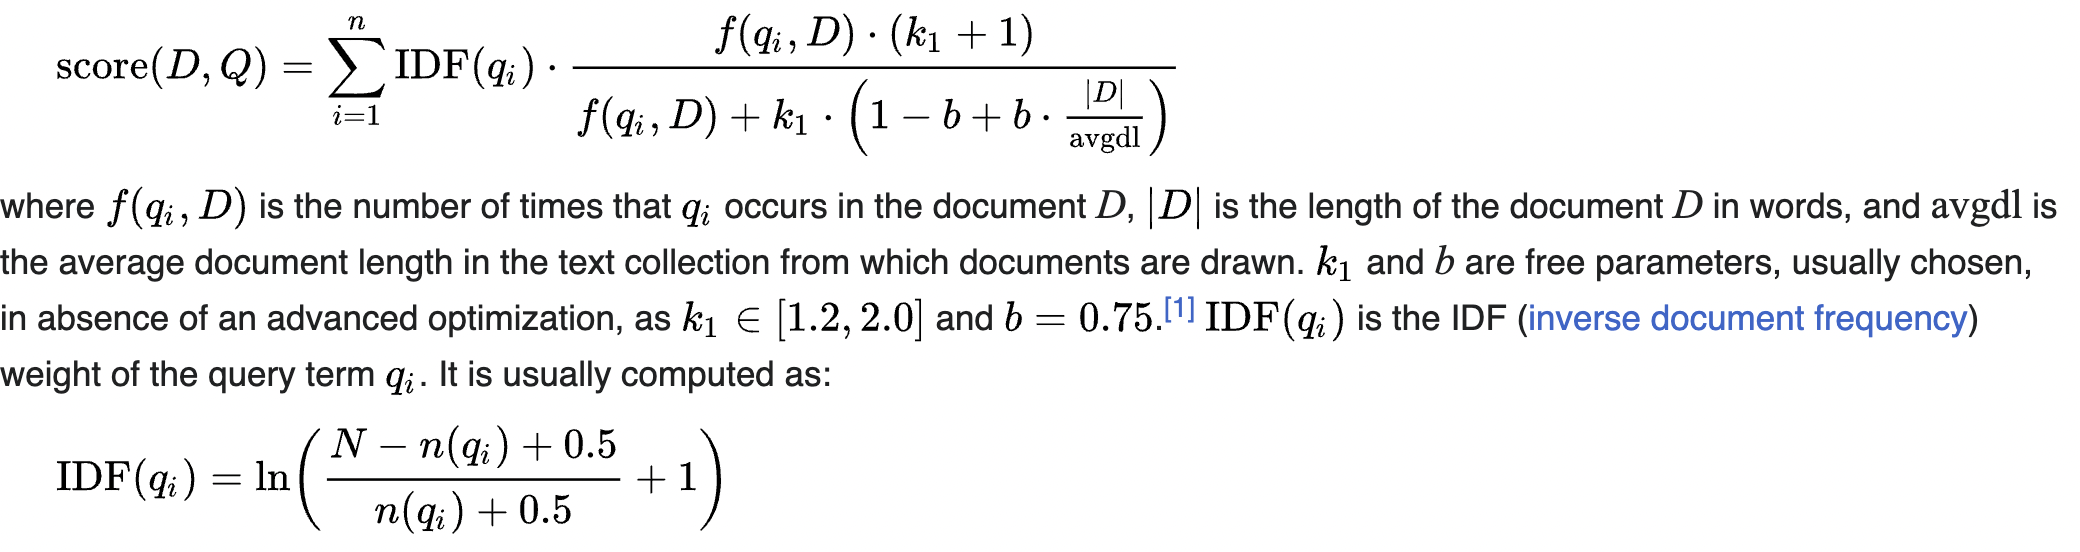)

In [69]:
def avgdl(docs):
    """
    computa o tamanho medio dos documentos na colecao
    
    retorna um float
    
    """
    doc_lengths = docs.apply(lambda x: len(x)) 
    
    return doc_lengths.mean()



def tf(word, doc):
    """
    computa o numero de vezes que um item da query em um documento
    
    retorna um float
    
    """
    return doc.count(word) / len(doc)



def weighted_tf(word, doc, docs, k1, b1):
    """
    computa o numero de documentos para um item da query
    
    retorna um float
    
    """
    
    a = tf(word, doc) * (k1+1)
    b = tf(word, doc) + k1 * (1. - b1 + b1 * len(doc)/avgdl(docs))
    
    
    return a/b




def freq(word, docs):
    """
    computa o numero de documentos para um item da query
    
    retorna um float
    
    """
    return sum(1 for doc in docs if word in doc)




def idf(word, docs):
    """
    computa o idf para um item da query
    
    retorna um float
    
    """  
    N_docs = docs.shape[0]
    
    #idf = np.log(N_docs - freq(word, docs) + 0.5) - np.log( freq(word,docs) + 0.5 )
    idf = np.log(N_docs + 1 ) - np.log( freq(word,docs) + 0.5 )

    return idf





def _calc_score(query, doc, docs, k1=1.5, b1=0.75):
    """
    computa o score de um documento, dada uma query
    
    retona float: score total por query por documento
    """ 
    
    score = 0
    for word in query:
        score += idf(word, docs) * weighted_tf(word, doc, docs, k1, b1)
    
    return score

In [70]:
#testando 
docs1 = df2_products['title_tokenized_bpe']
doc1 = df2_products['title_tokenized_bpe'][32]

query1 = ['lembrancinhar'] #tem que ser uma lista

_calc_score(query1, doc1, docs1)

0.654111738425851

In [46]:
import time

In [47]:
# Funcao que cria dictonario de palavras e scores: ---muito lento!!---

def bm25_indexing(docs, unique_words, k1=1.5, b1=0.75):
    
    """
    
    Cria os indices BM25 dos titulos dos produtos
    
    Retorna dicionario: 
       - key = "palavra"
       - value = list(indice do doc em docs , posicao da palavra em doc, bm25_score)
    
    """
    
    print('Criando o indice BM25 dos titulos dos produtos')
    
    worddic = {}

    tick = time.time()
    
    for index, doc in enumerate(docs):
        for word in unique_words['words']:
            if word in doc:
                #preciso colocar as palavras em listas para a funcao de score funcionar
                word_list = [word]
                #index = docsteste[docsteste[column].apply(lambda x: x==doc)].index[0]


                positions = list(np.where(np.array(docs[index]) == word)[0])

                bm25_score = _calc_score(word_list, doc, docs)

                # guardar indice e score do documento e que contem a palavra, 
                #e a posicao da palavra dentro documento para facilitar debugging
                try:
                    worddic[word].append([index,positions,bm25_score])
                except:
                    worddic[word] = []
                    worddic[word].append([index,positions,bm25_score])

            
            
    tock = time.time()
    print('Indexacao finalizada em ', round(tock - tick, 0), 'segundos')     
    
    return worddic



#selecionar dados para indexacao: forma nao otimizada

#column = 'title_tokenized_bpe'

#docsteste = pd.DataFrame(df2_products[column][:1000])

#docs = docsteste[column]

#cria lista de vocabulario em docs
#all_words = pd.DataFrame(np.concatenate(docs), columns=['words'])
#unique_words = all_words.value_counts().reset_index()

#unique_words.rename(columns={0: 'frequency'}, inplace=True)


#worddic = bm25_indexing(docs, unique_words)

In [71]:
#funcoes para criar dicionario de forma otimizada ---rodar essas---

def funct_doc(doc, word, docs, column_name):
    
    if word in doc:
        idx = docs[docs[column_name].apply(lambda x: x==doc)].index[0]
        
        #print(word, doc, idx)
        #print(np.where(np.array(docs[][idx]) == word))

        positions = list(np.where(np.array(doc) == word)[0])
        
        word_list = [word]
        
        score = _calc_score(word_list, doc, docs[column_name])
        
        return [idx, positions, score]
    
    return [np.nan, np.nan, np.nan]
    
    

def funct_words(word, docs, column_name):
    
    df_aux = pd.DataFrame()
    
    df_aux[column_name] = docs[column_name].apply(lambda doc: funct_doc(doc, word, docs, column_name))
    
    list_by_words = list(df_aux[df_aux[column_name].apply(lambda x: x!=[np.nan, np.nan, np.nan])][column_name]) 
    
    return list_by_words

In [92]:
column_name = 'tags_tokenized_bpe'

docsteste = df2_products[:10000]

#cria lista de vocabulario das queries
all_query_words = pd.DataFrame(np.concatenate(df2_pairs['query_tokenized_bpe']), columns=['words'])
unique_words = all_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

%time unique_words['scores'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )

#cria dicionario de vocabulario e scores
worddict = dict(zip(unique_words.words, unique_words.scores))

CPU times: user 42min 44s, sys: 10.2 s, total: 42min 54s
Wall time: 43min 18s


In [88]:
{'1000':31.6, '10000':, "20000": }

,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized,title_tokenized_bpe,tags_tokenized_bpe,category_tokenized_bpe
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0,"[jogo, banheiro, croche, 3, peca]","[jogobanheiro, crochar, tapete, decoracao, cor, chumbo, roso, beber]","[tecnica, artesanato]","[jogo, banheiro, croche, 3, pe, ca]","[jogo, banheiro, cro, char, tapete, decoracao, cor, chu, m, bo, roso, beber]","[te, c, n, ica, artesanato]"
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, guradanapo, festa, evento, 15, ano, casamento, aniversario]",[casa],"[guardanapo, tecido, 10, 0, un, idade]","[guardanapo, tecido, gu, ra, d, ana, po, festa, evento, 15, ano, casamento, aniversario]",[casa]
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0,"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, crochet]",[casa],"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, croche, t]",[casa]
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2,"[caixar, 1, bis, feliz, natal, cliente, voce, sempre, querer]","[lembranca, personalizar, festa, caixa, caixinho, rose, gold, folha, folhagem, verde, branco, verde, branco, minnie, roso, minnie, rosa, jardim, jardim, encantar, far, morena, fadinha, pj, pjmask, natal, ano, novo, feliz, natal, brinde, corporativo, card, bis, cartao, natal]",[lembrancinha],"[caixar, 1, bis, feliz, natal, cliente, vo, ce, sem, pr, e, qu, er, er]","[lembranca, personalizar, festa, caixa, caix, inho, rose, go, l, d, fol, ha, fol, h, agem, verde, branco, verde, branco, minnie, roso, minnie, rosa, jardim, jardim, encantar, far, m, or, en, a, f, ad, inha, p, j, p, j, mas, k, natal, ano, novo, feliz, natal, brinde, corporativo, car, d, bis, cartao, natal]",[lembrancinha]
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0,"[arvore, natal, decorar, mdf]","[madajoartesanato, decoracaodenatal, enfeitedenatal, arvoredenataldecoradaemmdfr]",[decoracao],"[arvore, natal, decorar, mdf]","[m, ada, jo, artesanato, decoracao, d, en, atal, enfeite, d, en, atal, arvore, d, en, atal, deco, ra, da, em, m, d, fr]",[decoracao]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76706,76765,12277,sacolinha para lembrancinhas,"['sacola para lembrancinhas', 'lembrancinhas', 'sacola', 'sacolinhas', 'sacolinha para lembrancinha']",2012-01-29 02:56:46,39.0,100.0,0,bolsas e carteiras,10,117,3,0,0,"[sacolinha, lembrancinha]","[sacola, lembrancinha, lembrancinha, sacola, sacolinho, sacolinha, lembrancinhar]","[bolsa, carteira]","[sacolinha, lembrancinha]","[sacola, lembrancinha, lembrancinha, sacola, sacolinho, sacolinha, lembrancinhar]","[bolsa, carteira]"
76707,76766,17945,kit pulseira e gravatas para padrinhos verde tiffany,"['manual para padrinhos', 'le

In [75]:
#testar
#testando se o dicionario esta funcionado como o esperado 
print(_calc_score(['lembrancinhar'], docsteste[column_name][32], docsteste[column_name]))

print(worddict['lembrancinhar'][2])

#passou no teste!

0.6476940301539361
[32, [0], 0.6476940301539361]


# Criar dicionarios de scores
Agora que verifiquei que o dicionario esta funcionando normalmente, vou usar a funcao para criar um dicionario para cada feature textual de produto:

* worddic_title: palavras e scoers em title_tokenized_bpe
* worddic_tags: palavras e scores em title_tokenized_bpe
* worddic_category: palavras e scores em title_tokenized_bpe

Esse passo é demorado, mas só preciso fazer uma vez!

In [77]:
# construir dict para todas as palavras nos documentos de title

column_name = 'title_tokenized_bpe'

docsteste = df2_products[:100]

#cria lista de vocabulario em queries
all_query_words = pd.DataFrame(np.concatenate(df2_pairs['query_tokenized_bpe']), columns=['words'])
unique_words = all_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

%time unique_words['scores'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )

#cria dicionario de vocabulario e scores
worddict_query = dict(zip(unique_words.words, unique_words.scores))

KeyboardInterrupt: 

AttributeError: 'DataFrame' object has no attribute 'scores'

In [ ]:
# construir dict para todas as palavras nos documentos de tags

column = 'tags_tokenized_bpe'

docs = df2_products[column]

#cria lista de vocabulario em docs
all_words = pd.DataFrame(np.concatenate(docs), columns=['words'])
unique_words = all_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)


worddic_tags = bm25_indexing(docs, unique_words)

# 3. Querying o Indice

Tem dois tipos de query que eu quero lidar: **queries padrao**, onde pelo menos uma das palavras na query aparece no documento, e **queries de frase**, onde todas as palavras da query aparecem no documento na mesma ordem - esse tipo de quety parece ser **mais util** para **queries por título de produtos**!


Como ja limpamos, normalizamos e tokenizamos as queries junto com os documentos, vou seguir direto para a construcao da **funcao para queries de frase**. Primeiro irei:
* resgatar as listas por query_tokenized_bpe
* para cada lista 

In [ ]:
def phrase_query(string, invertedIndex):
	pattern = re.compile('[\W_]+')
	string = pattern.sub(' ',string)
	listOfLists, result = [],[]
	for word in string.split():
		listOfLists.append(one_word_query(word))
	setted = set(listOfLists[0]).intersection(*listOfLists)
	for doc in docs:
		temp = []
		for word in string.split():
			temp.append(invertedIndex[word][filename][:])
		for i in range(len(temp)):
			for ind in range(len(temp[i])):
				temp[i][ind] -= i
		if set(temp[0]).intersection(*temp):
			result.append(filename)
	return rankResults(result, string)

# 4. Metricas
# 4.1 Trade-off entre Precisao e Recall

The principle takes into account that there is uncertainty in the representation of the information need and the documents. There can be a variety of sources of evidence that are used by the probabilistic retrieval methods, and the most common one is the statistical distribution of the terms in both the relevant and non-relevant documents.

# Sistema de recomendação: Content-Based Filtering
A recomendação é feita baseada nas **features de usuário** e nas **features dos produtos**. O match entre usuario e produto é feito pelo produto escalar:

## $ y^{i,j} = \vec{v}_{u}^{i}\cdot \vec{v}_{p}^{j}$

onde $\vec{v}_{u}^{i}$ e $\vec{v}_{p}^{j}$ são vetores computados das features do usuario $i$ e do produto $j$, respetivamente.

Muitos algoritmos de content-based filtering estimam $\vec{v}_{u}^{i}$ e  $\vec{v}_{p}^{j}$ usando redes neurais com a seguinte funcao de de custo:
## $J = \sum_{i,j}\left( \vec{v}_{u}^{i}\cdot \vec{v}_{p}^{j} -  y^{i,j} \right)^2 + \text{termos de regularização}$

Esse algoritmo tambem pode ser utilizado para *encontrar produtos similares*. Para isso, calculamos a distancia entre as features
## $ ||\vec{v}_{u}^{i} - \vec{v}_{p}^{j}||^2$

# Recomendação em grandes catálogos
O banco de dados contem mais de 6 milhoes de produtos. Portanto, o algoritmo pode ser computacionalmente inviavel de rodar para tantos itens. Para remediar esse problema, podemos implementar o sistema de recomendação em duas etapas: **retrieval** e **ranking**.

## Retrieval
Gerar uma lista de produtos plausiveis de serem buscados para aquela query. Por exemplo:
1) 100 produtos mais vendidos, clicados e adicionados ao carrinho numa determinada categoria de produtos
2) ....


Retrieving mais itens resulta numa performance melhor a custo de recomendacoes mais lentas. Para analizar o trade-off entre performance e velocidade, podemos rodar experimentos para ver se recuperar itens adicionais resulta em recomendacoes mais relevantes para o usuario.

## Ranking

Dada a lista de itens gerada na etapa anterior, rankeie os melhores produtos usando o modelo de aprendizagem e mostre esses itens rankeados ao usuario